In [3]:
import random
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [29]:
#Hyperparameters
batch_size = 64
num_epochs = 200
learning_rate = 0.00003
num_features = 16




In [30]:
class Linear_VAE(nn.Module):
  def __init__(self):
    super(Linear_VAE, self).__init__()

    # encoder
    self.encoder = nn.Sequential(
        nn.Linear(in_features=784, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=num_features*2)
    )

    # decoder 
    self.decoder = nn.Sequential(
      nn.Linear(in_features=num_features, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=784),
      nn.Sigmoid()
    )


  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the encoder's latent space
    :param log_var: log variance from the encoder's latent space
    """
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like`for getting the input size
    sample = mu + (eps * std) # sampling as coming from the input space
    return sample
 
  def forward(self, x):
    # encoding
    x = self.encoder(x)
    x = x.view(-1, 2, num_features)
    # get `mu` and `log_var`
    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance
    # get the latent vector through reparameterization
    z = self.reparameterize(mu, log_var)

    # decoding
    reconstruction = self.decoder(z)
    return reconstruction, mu, log_var

model = Linear_VAE()
print(model)

Linear_VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [31]:
transform = transforms.Compose([
  transforms.ToTensor(),
])
# train and validation data
training_data = datasets.MNIST(
  root='../input/data',
  train=True,
  download=True,
  transform=transform
)
validation_data = datasets.MNIST(
  root='../input/data',
  train=False,
  download=True,
  transform=transform
)
training_data  = torch.utils.data.Subset(training_data, range(0, 10000-1))
validation_data  = torch.utils.data.Subset(validation_data, range(0, 2000-1))

# training and validation data loaders
train_loader = torch.utils.data.DataLoader(
  training_data,
  batch_size=batch_size,
  shuffle=True
)
val_loader = torch.utils.data.DataLoader(
  validation_data,
  batch_size=batch_size,
  shuffle=False
)

In [32]:
def final_loss(bce_loss, mu, logvar):
  """
  This function will add the reconstruction loss (BCELoss) and the 
  KL-Divergence.
  KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  :param bce_loss: recontruction loss
  :param mu: the mean from the latent vector
  :param logvar: log variance from the latent vector
  """
  BCE_loss = bce_loss 
  KL_Divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE_loss + KL_Divergence

In [33]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

def fit(model, dataloader):
  model.train()
  current_loss = 0.0
  for i, data in enumerate(dataloader):
    data, _ = data
    data = data.view(data.size(0), -1)
    optimizer.zero_grad()
    reconstruction, mu, logvar = model(data)
    BCE_loss = criterion(reconstruction, data)
    loss = final_loss(BCE_loss, mu, logvar)
    current_loss += loss.item()
    loss.backward()
    optimizer.step()
  training_loss = current_loss/len(dataloader.dataset)
  return training_loss

In [34]:
def validate(model, dataloader, samples):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for i, data in enumerate(dataloader):
      data, _ = data
      data = data.view(data.size(0), -1)
      reconstruction, mu, logvar = model(data)
      bce_loss = criterion(reconstruction, data)
      loss = final_loss(bce_loss, mu, logvar)
      running_loss += loss.item()

      # save the last batch input and output of every epoch
      if i == int(len(validation_data)/dataloader.batch_size) - 1:
        num_rows = 8
        samples.append(torch.cat((data.view(batch_size, 1, 28, 28)[:num_rows], 
                           reconstruction.view(batch_size, 1, 28, 28)[:num_rows])))

  validation_loss = running_loss/len(dataloader.dataset)
  return validation_loss

In [35]:
train_loss = []
val_loss = []
samples = []

for epoch in range(num_epochs):
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader, samples)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print('Epoch [{:5d}/{:5d}] | Training loss: {:6.4f} | Validation loss: {:6.4f}'.format(
                    epoch+1, num_epochs, train_epoch_loss, val_epoch_loss))

Epoch [    1/  200] | Training loss: 452.6697 | Validation loss: 329.1035
Epoch [    2/  200] | Training loss: 286.3714 | Validation loss: 255.9782
Epoch [    3/  200] | Training loss: 250.4971 | Validation loss: 237.2588
Epoch [    4/  200] | Training loss: 237.2842 | Validation loss: 227.5941
Epoch [    5/  200] | Training loss: 228.9305 | Validation loss: 220.5075
Epoch [    6/  200] | Training loss: 222.0389 | Validation loss: 213.3645
Epoch [    7/  200] | Training loss: 214.6185 | Validation loss: 206.7861
Epoch [    8/  200] | Training loss: 207.9587 | Validation loss: 200.2569
Epoch [    9/  200] | Training loss: 200.9667 | Validation loss: 193.6953
Epoch [   10/  200] | Training loss: 194.1435 | Validation loss: 187.2694
Epoch [   11/  200] | Training loss: 187.6213 | Validation loss: 181.9059
Epoch [   12/  200] | Training loss: 182.2144 | Validation loss: 177.4127
Epoch [   13/  200] | Training loss: 177.5266 | Validation loss: 173.4959
Epoch [   14/  200] | Training loss: 1

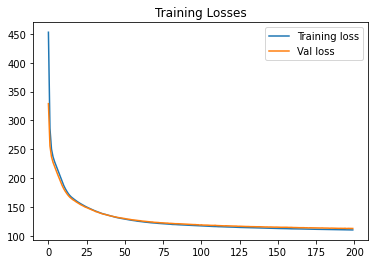

In [36]:
fig, ax = plt.subplots()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Val loss')
plt.title("Training Losses")
plt.legend()

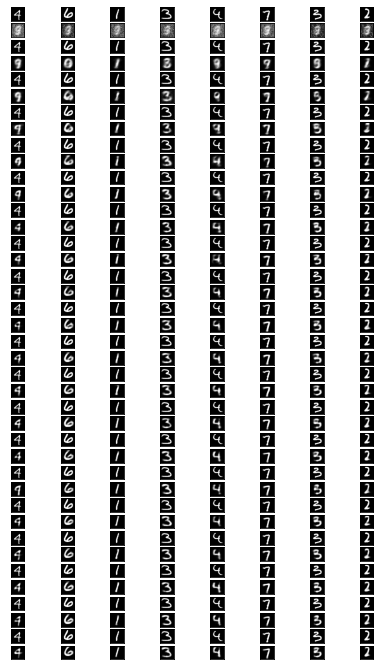

In [37]:
def view_samples(samples, axes):
  for i, ax in enumerate(axes):
    img = samples[i,0,:]
    img = img.detach()
    ax.imshow(img, cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

rows = 20
fig, axes = plt.subplots(figsize=(7,12), nrows=2*rows, ncols=8, sharex=True, sharey=True)
flat_axes = [ax for ax_row in axes for ax in ax_row]

for row in range(rows):
  sample = samples[row * int(len(samples)/(rows))]
  view_samples(sample, flat_axes[row*16 : (row+1)*16])

torch.Size([12, 1, 28, 28])
torch.Size([12, 784])
torch.Size([12, 784])
torch.Size([24, 1, 28, 28])


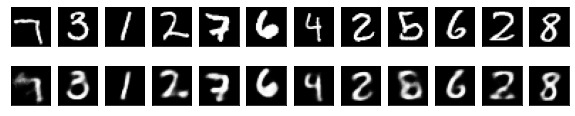

In [38]:
sample_size = 12
indices = random.sample(range(0, 2000-1), sample_size)
sample_subset = torch.utils.data.Subset(val_data, random.sample(range(0, 2000-1), 12))
loader = torch.utils.data.DataLoader(sample_subset, batch_size=sample_size)
sample, _ = next(iter(loader))
print(sample.size())
sample = sample.view(sample.size(0), -1)
print(sample.size())

model.eval()
reconstruction, _, _ = model(sample)
print(reconstruction.size())

out = torch.cat((sample.view(sample_size, 1, 28, 28), 
           reconstruction.view(sample_size, 1, 28, 28)))

print(out.size())

fig, axes = plt.subplots(figsize=(10,2), nrows=2, ncols=sample_size, sharex=True, sharey=True)
flat_axes = [ax for ax_row in axes for ax in ax_row]

view_samples(out, flat_axes)